# Grid World

В этом задании вам предстоит реализовать несколько алгоритмов классического обучения с подкреплением для решения нескольких вариантов задачи GridWorld. 

In [2]:
!pip install gym[all] pyvirtualdisplay > /dev/null 2>&1
!pip install tqdm > /dev/null 2>&1
!pip install pillow
!apt update > /dev/null 2>&1
!apt install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!wget https://noto-website-2.storage.googleapis.com/pkgs/NotoMono-hinted.zip > /dev/null 2>&1
!unzip NotoMono-hinted.zip > /dev/null 2>&1
!mv NotoMono-Regular.ttf /usr/share/fonts/truetype/ > /dev/null 2>&1

Defaulting to user installation because normal site-packages is not writeable
^C


In [1]:
import time
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import copy
import random
import numpy as np
from collections import deque
import random

%matplotlib inline

### Grid World
В этом задании Вам придется работать со средой Grid World. Мир представляет из себя ограниченную сетку, по которой может перемещаться агент. Некоторые клетки могут быть заблокированы, другие будут приводить к завершению путешествия агента с различным исходом.

#### Взаимодействие со средой
`get_actions(state)` возвращает список доступных в состонии `state` действий.

`get_states()` возвращает все состояния, в которых когда-либо может быть агент.

`get_transition(state, action)` возвращает состояние, в котором окажется агент если совершит действие `action` в состоянии `state`.

`get_reward(state, action)` возвращает награду, которую получит агент если совершит действие `action` в состоянии `state`.

`step(action)` - метод, позволяющий совершить действие в среде. На вход принимает действия из набора доступных действий, на выход возвращает `state, reward, done`. Награда является вещественным числом, done может принимать значения `True` или `False`

`reset()` - метод, позволяющий вернуть среду к изначальному состоянию. Обычно используется после того, как done принял значение `True`.

In [2]:
class GridWorld:
    def __init__(self, grid):
        self._height = len(grid)
        self._width = len(grid[0])
        self._max_reward = -1e9
        self._min_reward = 1e9
        for i in range(self._height):
            for j in range(self._width):
                if grid[i][j] == 'S':
                    self._start_state = (i, j)
                if not isinstance(grid[i][j], str):
                    self._max_reward = max(grid[i][j], self._max_reward)
                    self._min_reward = min(grid[i][j], self._min_reward)
        self._state = self._start_state
        self._grid = grid
    
    def step(self, action): # for Q learning
        reward = self.get_reward(self._state, action)
        next_state = self.get_transition(self._state, action)
        self._state = next_state
        done = next_state[0] < 0 or next_state[1] < 0
        return next_state, reward, done
    
    def reset(self): # for Q learning
        self._state = self._start_state
        return self._state
    
    def _get_info(self, x, y):
        reward = self._grid[y][x]
        if isinstance(reward, str):
            reward = 0.0
            is_final = False
        else:
            is_final = True
        is_block = self._grid[y][x] == "#"
        return reward, is_final, is_block
    
    def get_actions(self, state):
        return "left", "right", "top", "bottom"
    
    def get_states(self):
        states = []
        for i in range(self._height):
            for j in range(self._width):
                if self._grid[i][j] != '#':
                    states.append((i, j))
        return tuple(states)
    
    def get_transition(self, state, action):
        y, x = state
        if (y < 0) or (x < 0):
            return state
        if not isinstance(self._grid[y][x], str):
            return -1, -1
        if self._grid[y][x] == '#':
            return state
        if action == 'left' and x > 0 and self._grid[y][x - 1] != '#':
            return y, x - 1
        if action == 'right' and x < self._width - 1 and self._grid[y][x + 1] != '#':
            return y, x + 1
        if action == 'top' and y > 0 and self._grid[y - 1][x] != '#':
            return y - 1, x
        if action == 'bottom' and y < self._height - 1 and self._grid[y + 1][x] != '#':
            return y + 1, x
        return state
    
    def get_reward(self, state, action):
        next_state = self.get_transition(state, action)
        if state[0] < 0 or state[1] < 0:
            return 0.0
        if next_state[0] == state[0] and next_state[1] == state[1]:
            return 0.0
        if isinstance(self._grid[state[0]][state[1]], str):
            return 0.0
        return self._grid[state[0]][state[1]]

### ТЕХНИЧЕСКАЯ ЧАСТЬ
Тут лежит код для отображения картинок

In [3]:
class GridworldRanderer:
    def __init__(self, gridworld, cell_px=128, border_px=32, font_size=18):
        self.gridworld = gridworld
        self.cell_px = cell_px
        self.width = self.gridworld._width
        self.height = self.gridworld._height
        self.border_px = border_px 
        self.image = Image.new('RGB', (self.gridworld._width * cell_px + 2 * border_px,
                                      self.gridworld._height * cell_px + 2 * border_px), 
                              (0, 0, 0))
        self.drawer = ImageDraw.Draw(self.image)
        self.font = ImageFont.truetype("NotoMono-Regular.ttf", font_size)
        
    def _render_borders(self, is_q=False):
        self.drawer.line([(self.border_px, self.border_px), 
                          (self.border_px + self.width * self.cell_px, self.border_px), 
                          (self.border_px + self.width * self.cell_px, self.border_px + self.height * self.cell_px), 
                          (self.border_px, self.border_px + self.height * self.cell_px), 
                          (self.border_px, self.border_px)], fill=(255, 255, 255), width=6)
        for i in range(self.width - 1):
            self.drawer.line([(self.border_px + (i + 1) * self.cell_px, self.border_px), 
                              (self.border_px + (i + 1) * self.cell_px, self.border_px + self.height * self.cell_px)], 
                             fill=(255, 255, 255), width=4)
        for i in range(self.height - 1):
            self.drawer.line([(self.border_px, self.border_px + (i + 1) * self.cell_px), 
                              (self.border_px + self.width * self.cell_px, self.border_px + (i + 1) * self.cell_px)], 
                             fill=(255, 255, 255), width=4)
        for i in range(self.width):
            for j in range(self.height):
                reward, is_final, is_block = self.gridworld._get_info(i, j)
                if is_final:
                    self.drawer.line([(self.border_px + (i) * self.cell_px + 8, self.border_px + (j) * self.cell_px + 8), 
                                      (self.border_px + (i + 1) * self.cell_px - 8, self.border_px + (j) * self.cell_px + 8), 
                                      (self.border_px + (i + 1) * self.cell_px - 8, self.border_px + (j + 1) * self.cell_px - 8), 
                                      (self.border_px + (i) * self.cell_px + 8, self.border_px + (j + 1) * self.cell_px - 8), 
                                      (self.border_px + (i) * self.cell_px + 8, self.border_px + (j) * self.cell_px + 8)], fill=(255, 255, 255), width=2)
                elif is_q and not is_block:
                    self.drawer.line([
                        (self.border_px + i * self.cell_px, self.border_px + j * self.cell_px),
                        (self.border_px + (i + 1) * self.cell_px, self.border_px + (j + 1) * self.cell_px)], 
                        fill=(255, 255, 255), width=2)
                    self.drawer.line([
                        (self.border_px + i * self.cell_px, self.border_px + (j + 1) * self.cell_px),
                        (self.border_px + (i + 1) * self.cell_px, self.border_px + j * self.cell_px)], 
                        fill=(255, 255, 255), width=2)
        
    def _clear(self):
        self.image = Image.new('RGB', (self.gridworld._width * self.cell_px + 2 * self.border_px,
                                      self.gridworld._height * self.cell_px + 2 * self.border_px), 
                              (0, 0, 0))
        self.drawer = ImageDraw.Draw(self.image)
        self.drawer.font = self.font
    
    def _render_value_squere(self, x, y, v, min_v, max_v, is_final):
        if v == 0:
            color = (0, 0, 0)
        elif v > 0:
            color = (0, int(255 * min(abs(v) / (abs(max_v) + 1e-8), 1.0)), 0)
        else:
            color = (int(255 * min(abs(v) / (abs(min_v) + 1e-8), 1.0)), 0, 0)
        self.drawer.rectangle([self.border_px + x * self.cell_px, self.border_px + y * self.cell_px,
                              self.border_px + (x + 1) * self.cell_px, self.border_px + (y + 1) * self.cell_px],
                             fill=color)
        s = f"{v:.2f}"
        tx, ty = self.drawer.textsize(s)
        self.drawer.text((
            self.border_px + x * self.cell_px + self.cell_px // 2 - tx // 2,
            self.border_px + y * self.cell_px + self.cell_px // 2 - ty // 2
        ), s, fill=(255, 255, 255), stroke_width=1, stroke_fill=(0, 0, 0))
    
    def _render_q_squere(self, x, y, qs, min_v, max_v, is_final):
        actions = [("top", 0), ("right", 1), ("bottom", 2), ("left", 3)]
        for k, a in actions:
            v = qs[k]
            if v == 0:
                color = (0, 0, 0)
            elif v > 0:
                color = (0, int(255 * min(abs(v) / (abs(max_v) + 1e-8), 1.0)), 0)
            else:
                color = (int(255 * min(abs(v) / (abs(min_v) + 1e-8), 1.0)), 0 , 0)
            self.drawer.polygon([
                self.border_px + (x + (a + 1) // 2 % 2) * self.cell_px, self.border_px + (y + (a + 1) // 2 % 2) * self.cell_px,
                self.border_px + x * self.cell_px + self.cell_px // 2, self.border_px + y * self.cell_px  + self.cell_px // 2,
                self.border_px + (x + (a // 2 + 1) % 2) * self.cell_px, self.border_px + (y + (a // 2) % 2) * self.cell_px
            ], fill=color)
            dx = 0.5 + 0.25 * (a % 2) * (1 - 2 * (a // 2))
            dy = 0.5 + 0.25 * ((a + 1) % 2) * (2 * (a // 2) - 1)
            tpx = self.border_px + int((x + dx) * self.cell_px)
            tpy = self.border_px + int((y + dy) * self.cell_px)
            s = f"{v:.2f}"
            tx, ty = self.drawer.textsize(s)
            self.drawer.text((tpx - tx // 2, tpy - ty // 2), s, 
                             fill=(255, 255, 255), stroke_width=0, stroke_fill=(0, 0, 0))
            
    def render_rewards(self):
        self._clear()
        max_v = self.gridworld._max_reward
        min_v = self.gridworld._min_reward
        for i in range(self.width):
            for j in range(self.height):
                reward, is_final, is_block = self.gridworld._get_info(i, j)
                if is_block: 
                    continue
                self._render_value_squere(i, j, reward, min_v, max_v, is_final)
        self._render_borders()
        return np.array(self.image)
    
    def render_value(self, agent):
        self._clear()
        max_v = self.gridworld._max_reward
        min_v = self.gridworld._min_reward
        for i in range(self.width):
            for j in range(self.height):
                reward, is_final, is_block = self.gridworld._get_info(i, j)
                if is_block: 
                    continue
                if is_final:
                    self._render_value_squere(i, j, reward, min_v, max_v, is_final)
                else:
                    value = agent.get_value((j, i))
                    self._render_value_squere(i, j, value, min_v, max_v, is_final)
        self._render_borders()
        return np.array(self.image)
    
    def render_q(self, agent):
        self._clear()
        max_v = self.gridworld._max_reward
        min_v = self.gridworld._min_reward
        for i in range(self.width):
            for j in range(self.height):
                reward, is_final, is_block = self.gridworld._get_info(i, j)
                if is_block: 
                    continue
                if is_final:
                    self._render_value_squere(i, j, reward, min_v, max_v, is_final)
                else:
                    qs = {}
                    for a in self.gridworld.get_actions((i, j)):
                        qs[a] = agent.get_q((j, i), a)
                    self._render_q_squere(i, j,qs, min_v, max_v, is_final)
        self._render_borders(True)
        return np.array(self.image)

In [4]:
def _show_image(img, title=None, figsize=(9, 9)):
    fig = plt.figure(figsize=figsize)
    plt.xticks([])
    plt.yticks([])
    plt.title(title)
    plt.tight_layout()
    plt.imshow(img)
    plt.show()

def visualise_value_iteration(gridworld, agent):
    randerer = GridworldRanderer(gridworld)
    _show_image(randerer.render_rewards(), "Environment")
    _show_image(randerer.render_value(agent), "Value function")
    
def visualise_q_learning(gridworld, agent):
    randerer = GridworldRanderer(gridworld)
    _show_image(randerer.render_rewards(), "Environment")
    _show_image(randerer.render_q(agent), "Q function")

### Различные миры
В этой части определены различные миры. Каждый из них так или иначе раскрывает возможные проблемы алгоритмов обучения с подкреплением.

In [5]:
classic_grid = [
    [" ", " ", " ", 1.0],
    [" ", "#", " ", -1.0],
    ["S", " ", " ", " "]
]
exploration_grid = [
    [" ", " ", " ", 1.0],
    [" ", "#", " ", 2.0],
    ["S", " ", " ", " "]
]
cliff_grid = [
    [" ", " ", " ", " ", " "],
    [" ", "#", "#", "#", " "],
    ["S", " ", " ", " ", 1.0],
    [-1.0, -1.0, -1.0, -1.0, -1.0]
]
cliff_exploration_grid = [
    [" ", " ", " ", " ", " ", " ", " "],
    [" ", "#", "#", "#", "#", "#", " "],
    [" ", " ", " ", " ", " ", 1.0, " "],
    [" ", "#", "#", "#", "#", "#", 8.0],
    ["S", " ", " ", " ", " ", " ", 1.0],
    [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]
]
hard_exploration_grid = [
    [" ", " ", " ", " ", " ", " ", " "],
    [" ", "#", "#", "#", "#", "#", " "],
    [" ", " ", " ", " ", " ", 3.0, " "],
    [" ", "#", "#", "#", "#", "#", " "],
    [" ", " ", " ", " ", " ", 2.0, " "],
    [" ", "#", "#", "#", "#", "#", " "],
    ["S", " ", " ", " ", " ", 1.0, 10.0],
]

### Общий интерфейс для агента
`get_action(state)` возвращает состояние, которое хочет совершить агент в состоянии `state`

`get_value(state)` возвращает значение Value-function для состояния `state`

`get_q(state, action)` возвращает значение Q-function для состояния `state` и действия `action`

In [6]:
class Agent:
    def get_action(self, state):
        pass
    
    def get_value(self, state):
        pass
    
    def get_q(self, state, action):
        pass

### Задание 1 (4 балла)
Реализуйте алгоритм value iteration. Обучение должно проходить в методе `__init__` в течении `iterations` итераций. Каждая итерация включает в себя проход по всем возможным состояниям среды. Во время обучения нужно учитывать learning rate `alpha` и коэффициент дисконтирования `gamma`.

_Hint:_ используйте методы `gridworld.get_reward`, `gridworld.get_transition`, `gridworld.get_actions` и `gridworld.get_states`

In [7]:
class ValueIteration(Agent):
    def __init__(self, gridworld, iterations=1000, alpha=0.9, gamma=0.8):
        self.gamma = gamma
        self.alpha = alpha
        self.gridworld = gridworld
        self.value_funcs = np.zeros((gridworld._height, gridworld._width))
        for i in range(iterations):
            cur_value_funcs = np.zeros(self.value_funcs.shape)
            for state in self.gridworld.get_states():
                reward, is_final, _ = self.gridworld._get_info(state[1], state[0])
                if is_final:
                    cur_value_funcs[state] = reward
                    continue
                
                best_action = self.get_action(state)
                best_transition = self.gridworld.get_transition(state, best_action)
                cur_value_funcs[state] = \
                    (1 - self.alpha) * self.value_funcs[state] + \
                    self.alpha * (self.gridworld.get_reward(state, best_action) + self.gamma * self.value_funcs[best_transition])
            self.value_funcs = cur_value_funcs
    
    def get_action(self, state):
        best_action = None
        best_reward = -1e9
        for action in self.gridworld.get_actions(state):
            new_state = self.gridworld.get_transition(state, action)
            reward = self.gridworld.get_reward(state, action) + self.value_funcs[new_state[0], new_state[1]]
            if reward > best_reward:
                best_reward = reward
                best_action = action
                
        return best_action
    
    def get_value(self, state):
        return self.value_funcs[state]
    
    def get_q(self, state, action):
        return None

#### Посмотрим, что получилось
Для проверки алгоритма можно использовать различные варианты среды, полный список находится выше.

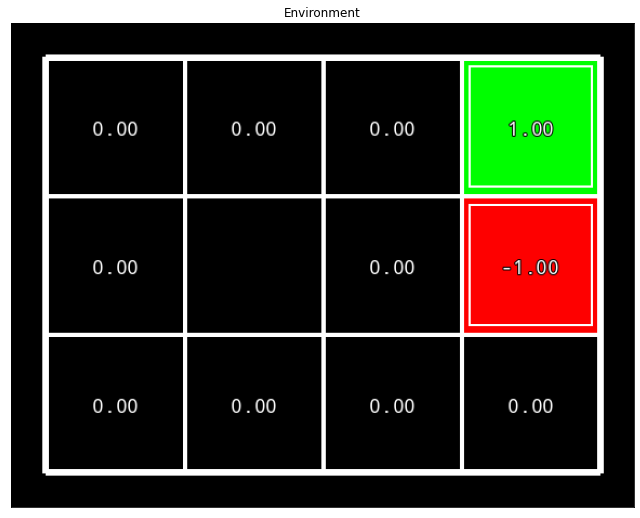

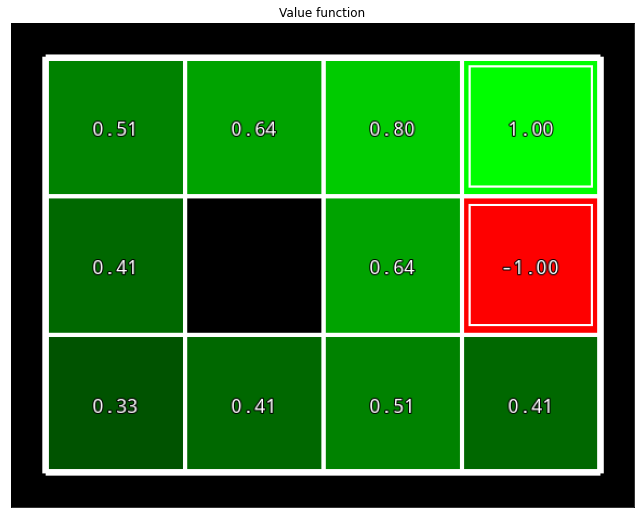

In [11]:
gridworld = GridWorld(classic_grid)

value_agent = ValueIteration(gridworld)

visualise_value_iteration(gridworld, value_agent)

### Задание 2 (4 балла)
Реализуйте алгоритм Q-learning. Процесс обучения реализован вне класса, поэтому достаточно реализовать метод `update` для пересчета значений Q-function. Во время обнвления нужно учитывать learning rate `alpha` и коэффициент дисконтирования `gamma`.

В этом задании использовать `gridworld.get_reward`, `gridworld.get_transition` и `gridworld.get_states` нельзя (`gridworld.get_actions` можно)

In [58]:
class QLearning(Agent):
    def __init__(self, gridworld, alpha=0.9, gamma=0.8):
        self.gamma = gamma
        self.alpha = alpha
        self.gridworld = gridworld
        all_actions = self.gridworld.get_actions((0, 0))
        self.q_funcs = np.zeros((gridworld._height, gridworld._width, len(all_actions)))
        self.action_to_number = dict(zip(all_actions, np.arange(len(all_actions))))

    def update(self, state, action, next_state, reward, done):
        next_action = QLearning.get_action(self, next_state)
        self.q_funcs[state[0], state[1], self.action_to_number[action]] = \
                (1 - self.alpha) * self.q_funcs[state[0], state[1], self.action_to_number[action]] + \
                self.alpha * (reward + self.gamma * (0 if done else self.q_funcs[next_state[0], next_state[1], self.action_to_number[next_action]]))
        
    def get_action(self, state):
        best_action = None
        best_qfunc_value = -1e9
        for action in self.gridworld.get_actions(state):
            qfunc_value = self.q_funcs[state[0], state[1], self.action_to_number[action]]
            if qfunc_value > best_qfunc_value:
                best_qfunc_value = qfunc_value
                best_action = action
                
        return best_action
    
    def get_value(self, state):
        return None
    
    def get_q(self, state, action):
        return self.q_funcs[state[0], state[1], self.action_to_number[action]]

Имплементация epsilon-greedy алгоритма. Просто добавляем случайные действия с вероятностью epsilon.

In [59]:
class EpsilonGreedy(QLearning):
    def __init__(self, gridworld, alpha=0.5, gamma=0.9, eps=0.1):
        self.eps = eps
        super().__init__(gridworld, alpha=alpha, gamma=gamma)
    
    def get_action(self, state):
        if self.eps > random.random():
            return random.choice(gridworld.get_actions(state))
        else:
            return super().get_action(state)

Процесс обучения Q-learning. Сначала обучаем агента в течении `timesteps` шагов среды, после чего тестируем его на `test_episodes` эпизодах с ограничением не более `test_max_steps` шагов на каждый. Возвращает количство завершившихся эпизодов во время тестирвания и сумму полученных наград.

In [60]:
def train(gridworld, agent, train_method, timesteps, test_episodes=100, test_max_steps=100):
    train_method(gridworld, agent, timesteps)
    time = 0
    done_count = 0
    sum_reward = 0
    for ep in range(test_episodes):
        done = False
        sr = 0.
        state = gridworld.reset()
        for time in range(test_max_steps):
            action = agent.get_action(state)
            state, reward, done = gridworld.step(action)
            sr += reward
            if done:
                done_count += 1
                sum_reward += sr
                break
    return done_count, sum_reward

def train_qlearning(gridworld, agent, timesteps):
    done = False
    state = gridworld.reset()
    for t in range(timesteps):
        if done:
            state = gridworld.reset()
            done = False
        action = agent.get_action(state)
        next_state, reward, done = gridworld.step(action)
        agent.update(state, action, next_state, reward, done)
        state = next_state

Посмотрим на зависимость результата от $\epsilon$. Можно посмотреть также и на разные среды

In [61]:
gridworld = GridWorld(classic_grid)
for eps in (0.0, 0.1, 0.25, 0.5, 0.75):
    agent = EpsilonGreedy(gridworld, eps=eps)
    done_count, sum_reward = train(gridworld, agent, train_qlearning, 1000000)
    if done_count != 0:
        sum_reward /= done_count
    print(f"Epsilon: {eps} | Done count: {done_count} | Avg reward {sum_reward}")

Epsilon: 0.0 | Done count: 0 | Avg reward 0
Epsilon: 0.1 | Done count: 100 | Avg reward 0.96
Epsilon: 0.25 | Done count: 100 | Avg reward 0.8
Epsilon: 0.5 | Done count: 100 | Avg reward 0.64
Epsilon: 0.75 | Done count: 100 | Avg reward 0.34


Done count: 100 | Avg reward 0.86


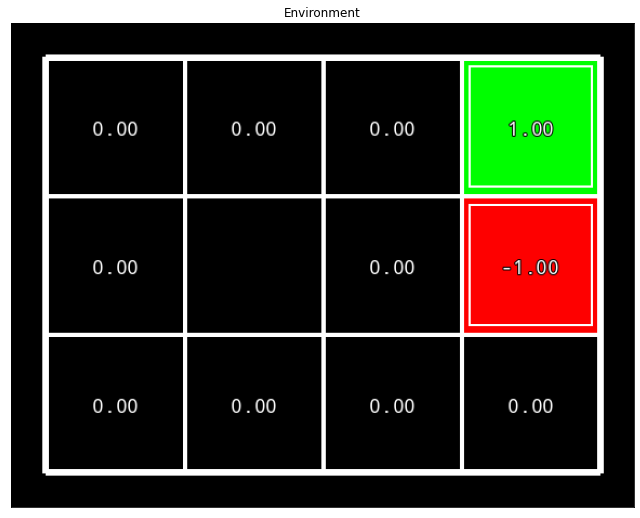

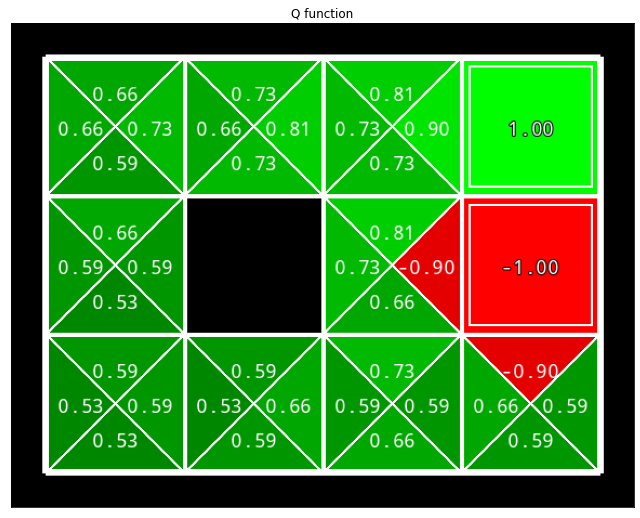

In [62]:
gridworld = GridWorld(classic_grid)
agent = EpsilonGreedy(gridworld, eps=0.2)
done_count, sum_reward = train(gridworld, agent, train_qlearning, 1000000)
if done_count != 0:
    sum_reward /= done_count
print(f"Done count: {done_count} | Avg reward {sum_reward}")
visualise_q_learning(gridworld, agent)

In [63]:
gridworld = GridWorld(cliff_grid)
for eps in (0.0, 0.1, 0.25, 0.5, 0.75):
    agent = EpsilonGreedy(gridworld, eps=eps)
    done_count, sum_reward = train(gridworld, agent, train_qlearning, 1000000)
    if done_count != 0:
        sum_reward /= done_count
    print(f"Epsilon: {eps} | Done count: {done_count} | Avg reward {sum_reward}")

Epsilon: 0.0 | Done count: 0 | Avg reward 0
Epsilon: 0.1 | Done count: 71 | Avg reward -1.0
Epsilon: 0.25 | Done count: 100 | Avg reward 0.6
Epsilon: 0.5 | Done count: 100 | Avg reward -0.08
Epsilon: 0.75 | Done count: 100 | Avg reward -0.46


Done count: 100 | Avg reward 0.56


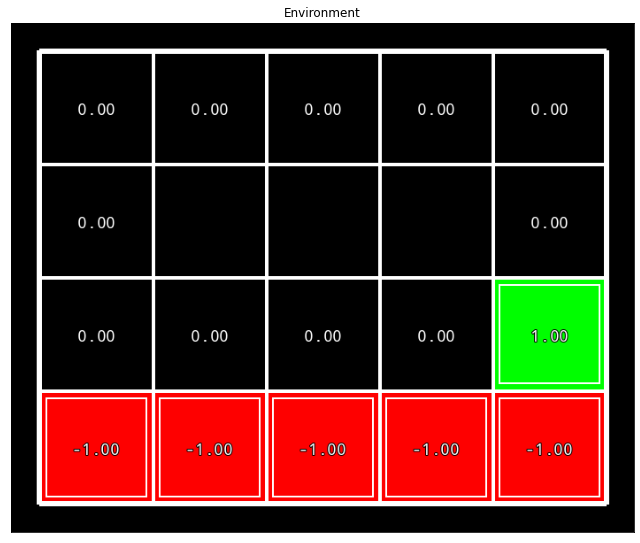

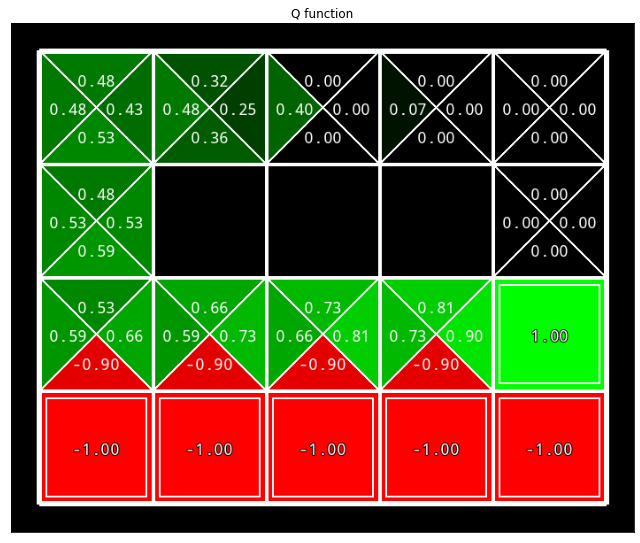

In [64]:
gridworld = GridWorld(cliff_grid)
agent = EpsilonGreedy(gridworld, eps=0.2)
done_count, sum_reward = train(gridworld, agent, train_qlearning, 1000000)
if done_count != 0:
    sum_reward /= done_count
print(f"Done count: {done_count} | Avg reward {sum_reward}")
visualise_q_learning(gridworld, agent)

Кажется, что в Cliff World у Q-learning действительно возникли проблемы, поэтому

### Задание 3 (2 балла)
Реализуйте алгоритм SARSA. Для этого Вам придется изменить метод `update`, а также реализовать процедуру `train_sarsa` аналогично процедуре `train_qlearning`.

В этом задании использовать `gridworld.get_reward`, `gridworld.get_transition` и `gridworld.get_states` нельзя (`gridworld.get_actions` можно)

_Hint:_ сейчас становится критичным подбор learning rate

In [65]:
class SARSA(EpsilonGreedy):
    def update(self, state, action, next_state, next_action, reward, done):
        self.q_funcs[state[0], state[1], self.action_to_number[action]] = \
                (1 - self.alpha) * self.q_funcs[state[0], state[1], self.action_to_number[action]] + \
                self.alpha * (reward + self.gamma * (0 if done else self.q_funcs[next_state[0], next_state[1], self.action_to_number[next_action]]))

def train_sarsa(gridworld, agent, timesteps):
    # TODO: Это просто копипаста метода train_qlearning. Его нужно адаптировать для обучения алгоритма SARSA
    done = False
    state = gridworld.reset()
    for t in range(timesteps):
        if done:
            state = gridworld.reset()
            done = False
        action = agent.get_action(state)
        next_state, reward, done = gridworld.step(action)
        next_action = agent.get_action(next_state)
        agent.update(state, action, next_state, next_action, reward, done)
        state = next_state

In [66]:
gridworld = GridWorld(cliff_grid)
for eps in (0.0, 0.1, 0.25, 0.5, 0.75):
    agent = SARSA(gridworld, eps=eps, alpha=0.2)
    done_count, sum_reward = train(gridworld, agent, train_sarsa, 1000000)
    if done_count != 0:
        sum_reward /= done_count
    print(f"Epsilon: {eps} | Done count: {done_count} | Avg reward {sum_reward}")

Epsilon: 0.0 | Done count: 0 | Avg reward 0
Epsilon: 0.1 | Done count: 100 | Avg reward 1.0
Epsilon: 0.25 | Done count: 100 | Avg reward 0.82
Epsilon: 0.5 | Done count: 100 | Avg reward 0.6
Epsilon: 0.75 | Done count: 100 | Avg reward 0.0


Done count: 100 | Avg reward 0.8


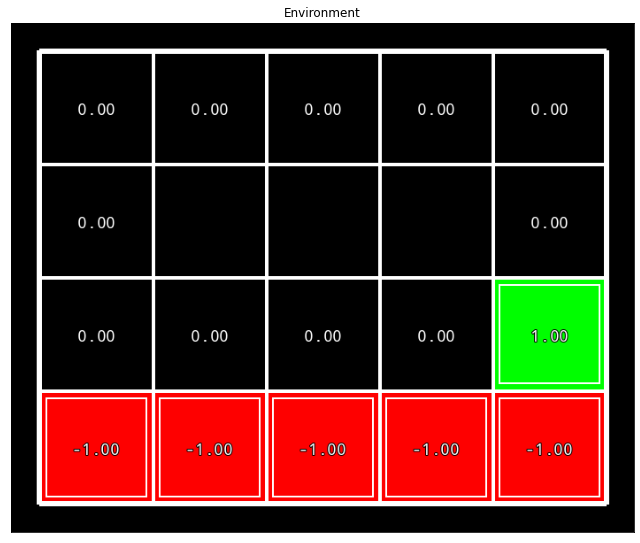

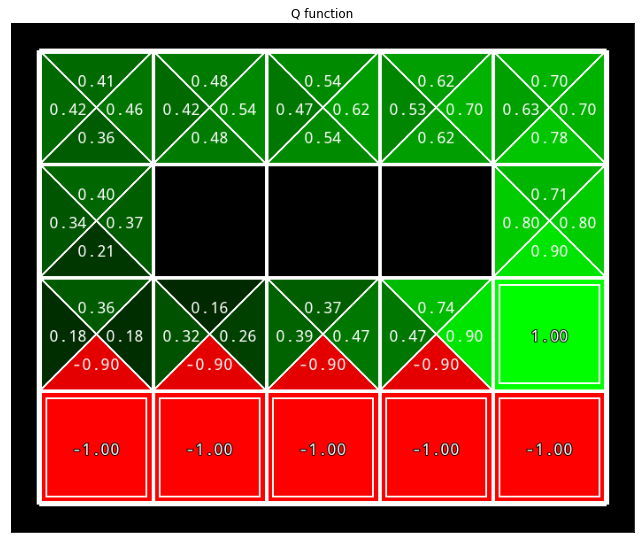

In [67]:
gridworld = GridWorld(cliff_grid)
agent = SARSA(gridworld, eps=0.2, alpha=0.2)
done_count, sum_reward = train(gridworld, agent, train_sarsa, 1000000)
if done_count != 0:
    sum_reward /= done_count
print(f"Done count: {done_count} | Avg reward {sum_reward}")
visualise_q_learning(gridworld, agent)

In [68]:
gridworld = GridWorld(cliff_exploration_grid)
for eps in (0.1, 0.2, 0.3, 0.5, 0.7):
    agent = SARSA(gridworld, eps=eps, alpha=0.2)
    done_count, sum_reward = train(gridworld, agent, train_sarsa, 1000000)
    if done_count != 0:
        sum_reward /= done_count
    print(f"Epsilon: {eps} | Done count: {done_count} | Avg reward {sum_reward}")

Epsilon: 0.1 | Done count: 100 | Avg reward 0.98
Epsilon: 0.2 | Done count: 100 | Avg reward 0.88
Epsilon: 0.3 | Done count: 100 | Avg reward 6.52
Epsilon: 0.5 | Done count: 100 | Avg reward 0.36
Epsilon: 0.7 | Done count: 100 | Avg reward 1.28


Done count: 100 | Avg reward 7.11


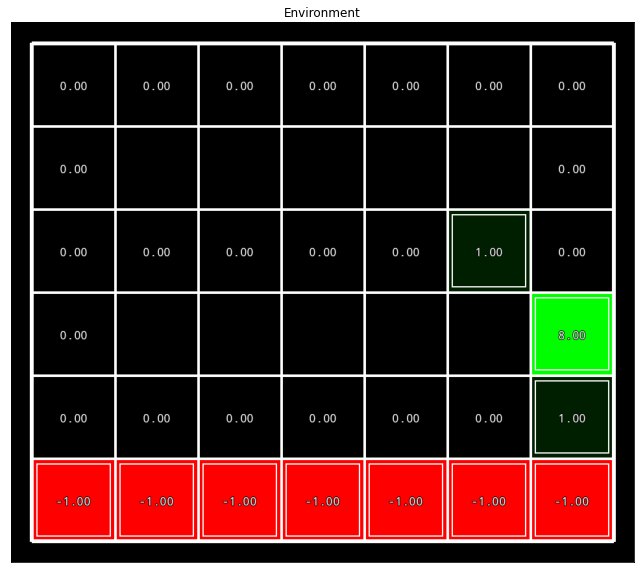

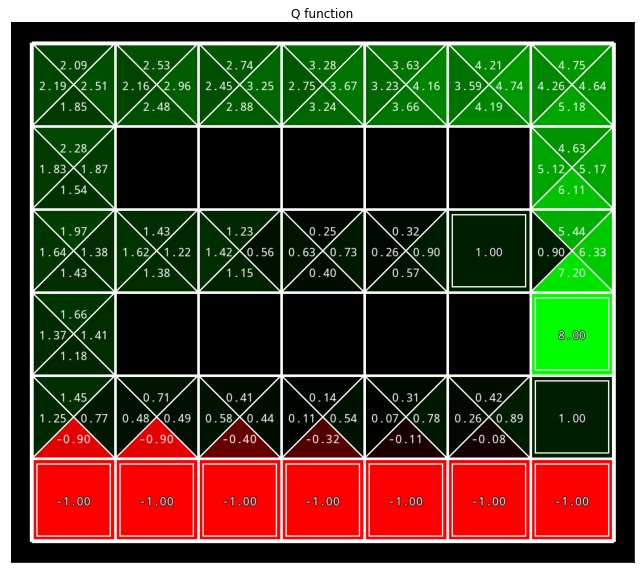

In [69]:
gridworld = GridWorld(cliff_exploration_grid)
agent = SARSA(gridworld, eps=0.2, alpha=0.2)
done_count, sum_reward = train(gridworld, agent, train_sarsa, 1000000)
if done_count != 0:
    sum_reward /= done_count
print(f"Done count: {done_count} | Avg reward {sum_reward}")
visualise_q_learning(gridworld, agent)